
<p><img src="https://oceanprotocol.com/static/media/banner-ocean-03@2x.b7272597.png" alt="drawing" width="800" align="center"/>

<h1><center>Ocean Protocol - Manta Ray project</center></h1>
<h3><center>Decentralized Data Science and Engineering, powered by Ocean Protocol</center></h3>
<p>Version 0.5.1 - beta</p>
<p>Package compatibility: squid-py v0.5.11, keeper-contracts 0.9.0, utilities 0.2.1,
<p>Component compatibility: Brizo v0.3.2, Aquarius v0.2.1, Nile testnet smart contracts 0.8.6</p>
<p><a href="https://github.com/oceanprotocol/mantaray">mantaray on Github</a></p>
<p>

-------------------

# Decentralized Data Science use case - Understanding the Amazon deforestation from Space challenge

This notebook demonstrates accessing a dataset from Ocean Protocol and training a deep learning classifier.

<p><img src="https://www.borgenmagazine.com/wp-content/uploads/2013/11/Deforestation.jpg" alt="drawing" width="1000" align="center"/>


Attribution: Source for this notebook was prepared by Tuatini Godard for the Kaggle Competition "Planet: Understanding the Amazon from Space"

See the [source kernel](https://www.kaggle.com/ekami66/0-92837-on-private-lb-solution-with-keras)

And the [source GitHub repository](https://github.com/EKami/planet-amazon-deforestation)

Modifications and refactoring made by M.Jones 17 May 2019
- Data source paths updated
- New plotting function
- Various formatting and comments

Below, the kernel;
-------------------


Special thanks to the kernel contributors of this challenge (especially @anokas and @Kaggoo) who helped me find a starting point for this notebook.

The whole code including the `data_helper.py` and `keras_helper.py` files are available on github [here](https://github.com/EKami/planet-amazon-deforestation) and the notebook can be found on the same github [here](https://github.com/EKami/planet-amazon-deforestation/blob/master/notebooks/amazon_forest_notebook.ipynb)

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

## Section 0: Prepare environment and libraries

In [1]:
# Logging
# =============================================================================
import sys
import logging

logger = logging.getLogger()
logger.handlers = []

# Set level
logger.setLevel(logging.INFO)

# Create formatter
FORMAT = "%(levelno)-2s %(asctime)s : %(message)s"
DATE_FMT = "%Y-%m-%d %H:%M:%S"
formatter = logging.Formatter(FORMAT, DATE_FMT)

# Create handler and assign
handler = logging.StreamHandler(sys.stderr)
handler.setFormatter(formatter)
logger.handlers = [handler]
logging.info("Logging started")

20 2019-05-17 15:18:05 : Logging started


In [2]:
from pathlib import Path

# Move to the project directory if inside a subdirectory (JupyterLab)
import os
cwd = Path.cwd().parts
if cwd[-1] == 'kernel_submission':
    cwd = cwd[0:-1]
    cwd = Path(*cwd)
    os.chdir(cwd)
    logging.info("Changed working directory to {}".format(cwd))

20 2019-05-17 15:18:05 : Changed working directory to /home/batman/kaggle/kaggle_amazon_rainforest


In [3]:
import warnings
import gc
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
# Scientific stack
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import sklearn as sk
import seaborn as sns
import h5py

logging.info("{:>10}=={} as {}".format('numpy', np.__version__, 'np'))
logging.info("{:>10}=={} as {}".format('pandas', pd.__version__, 'pd'))
logging.info("{:>10}=={} as {}".format('sklearn', sk.__version__, 'sk'))
logging.info("{:>10}=={} as {}".format('seaborn', sns.__version__, 'sns'))

20 2019-05-17 15:18:06 :      numpy==1.16.3 as np
20 2019-05-17 15:18:06 :     pandas==0.24.2 as pd
20 2019-05-17 15:18:06 :    sklearn==0.21.0 as sk
20 2019-05-17 15:18:06 :    seaborn==0.9.0 as sns


In [5]:
# Deep Learning
assert "LD_LIBRARY_PATH" in os.environ
# Deep learning stack
import tensorflow as tf
import tensorflow.keras as ks
logging.info("{:>10}=={} as {}".format('tensorflow', tf.__version__, 'tf'))
logging.info("{:>10}=={} as {}".format('keras', ks.__version__, 'ks'))

20 2019-05-17 15:18:06 : tensorflow==1.12.0 as tf
20 2019-05-17 15:18:06 :      keras==2.1.6-tf as ks


In [6]:

import os
# import gc
# import bcolz
# import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.keras.optimizers import Adam
# from keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
# import vgg16
# from utils import vgg16
# from . import utils
# from .. import utils
# import .utils
# from  .utils import vgg16
# from utils import vgg16
# import vgg16
# import data_helper

# import data_helper
from src.utils import vgg16
try:
    from src.utils import vgg16
    from src.utils import data_helper
    from src.utils.data_helper import AmazonPreprocessor
except:
    path_utils = Path.cwd() / '../src'
    assert path_utils.exists()
    sys.path.insert(0, str(path_utils.resolve()))
    from utils import vgg16
    from utils import data_helper
    from utils.data_helper import AmazonPreprocessor
# from src.utils import vgg16
# from src.utils import data_helper
# from src.utils.data_helper import AmazonPreprocessor
# from kaggle_data.downloader import KaggleDataDownloader

In [7]:
def mm2inch(value):
    return value/25.4
PAPER = {
    "A3_LANDSCAPE" : (mm2inch(420),mm2inch(297)),
    "A4_LANDSCAPE" : (mm2inch(297),mm2inch(210)),
    "A5_LANDSCAPE" : (mm2inch(210),mm2inch(148)),
}

## Section 1: Access and download the data from Ocean Protocol
Data asset Decentralized Identifier (did): `did:op:3fdcc402b9994d88828e82f9be16e40eaf8eed10036c48ae9a826415e3ca46ce`

Commons market link: [Amazon rainforest satellite imagery](https://commons.oceanprotocol.com/asset/did:op:3fdcc402b9994d88828e82f9be16e40eaf8eed10036c48ae9a826415e3ca46ce)

Optionally, download the data directly in your notebook environment:

```python
import logging
import os
from squid_py import Metadata, Ocean
import squid_py
import mantaray_utilities as manta_utils

# Setup logging
from mantaray_utilities.user import get_account_from_config
from mantaray_utilities.blockchain import subscribe_event
manta_utils.logging.logger.setLevel('INFO')
import mantaray_utilities as manta_utils
from squid_py import Config
from squid_py.keeper import Keeper
from pathlib import Path
import datetime
import web3

```

In [8]:
# The data path is relative to current path
from pathlib import Path
PATH_DATA_ROOT = Path.cwd() / "data"
if not PATH_DATA_ROOT.exists():
    PATH_DATA_ROOT = Path.cwd() / "../data"
assert PATH_DATA_ROOT.exists()

In [9]:
data_root_folder = Path.cwd() / 'data'
assert data_root_folder.exists()
train_jpeg_dir = data_root_folder / 'train-jpg'
assert train_jpeg_dir.exists()
test_jpeg_dir = data_root_folder / 'test-jpg'
assert test_jpeg_dir.exists()
test_jpeg_additional_dir = data_root_folder / 'test-jpg-additional'
assert test_jpeg_additional_dir.exists()
train_csv_file = data_root_folder / 'train_v2.csv'
assert train_csv_file.exists()

## Section 2: Basic data exploration and visualization


## Inspect image labels
Visualize what the training set looks like

In [10]:

# train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road



Each image can be tagged with multiple tags, lets list all uniques tags

In [11]:

# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("{} labels: {}".format(len(labels_set), labels_set))

17 labels: {'cultivation', 'agriculture', 'slash_burn', 'clear', 'cloudy', 'water', 'artisinal_mine', 'partly_cloudy', 'bare_ground', 'blow_down', 'selective_logging', 'habitation', 'haze', 'blooming', 'road', 'conventional_mine', 'primary'}


### Repartition of each labels

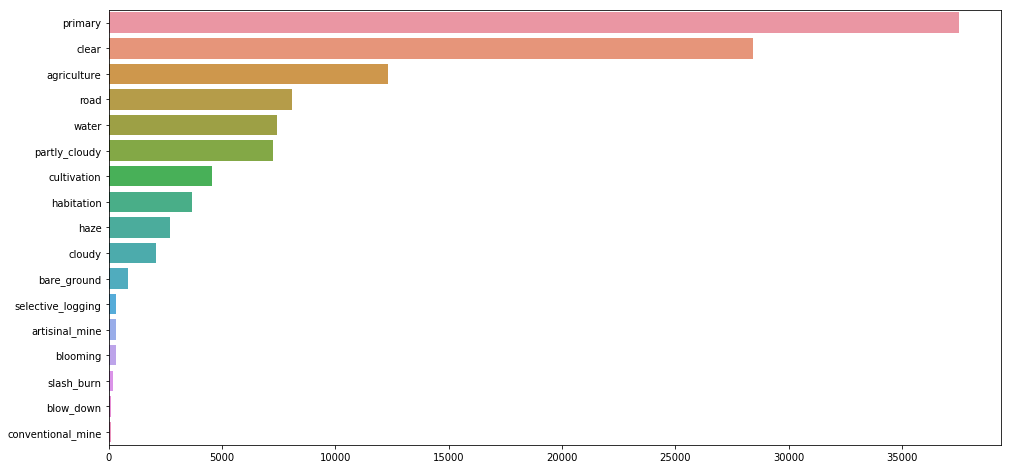

In [12]:

# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')
plt.show()


## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

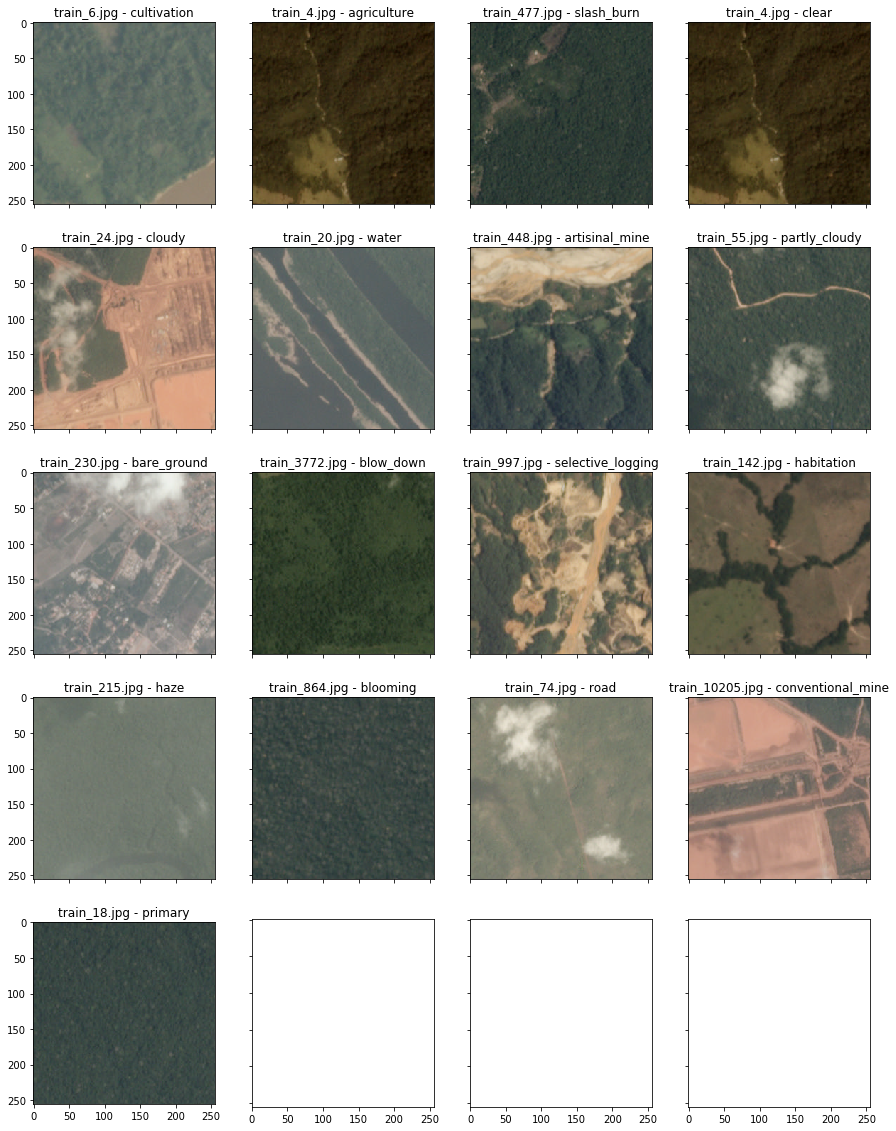

In [13]:

images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg'
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
#cols = 3
#rows = 3
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir / image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))
plt.show()# %% [markdown]
# ## Section 3: Pre-process images


# Image resize & validation split
Define the dimensions of the image data trained by the network. Recommended resized images could be 32x32, 64x64, or 128x128 to speedup the training.

You could also use `None` to use full sized images.

Be careful, the higher the `validation_split_size` the more RAM you will consume.

In [14]:

img_resize = (128, 128) # The resize size of each image ex: (64, 64) or None to use the default image size
validation_split_size = 0.2


# Data preprocessing
Due to the huge amount of memory the preprocessed images can take, we will create a dedicated `AmazonPreprocessor` class which job is to preprocess the data right in time at specific steps (training/inference) so that our RAM don't get completely filled by the preprocessed images.

The only exception to this being the validation dataset as we need to use it as-is for f2 score calculation as well as when we calculate the validation accuracy of each batch.

In [15]:

preprocessor = AmazonPreprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_jpeg_additional_dir,
                                  img_resize, validation_split_size)
preprocessor.init()

100%|██████████| 8096/8096 [00:00<00:00, 506255.46it/s]


Transforming val dataset...


100%|██████████| 8096/8096 [00:18<00:00, 449.26it/s]


Done. Size consumed by validation matrices 1518.0 mb


In [16]:

print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/X_test_filename length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.X_test_filename)))
preprocessor.y_map

X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/X_test_filename length: 61191/61191


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

## Section 4: Define model
Using Keras, a number of pre-trained models can be download automatically when instantiating a model. They are stored at ~/.keras/models/.

Alternatively, get a pre-trained model from  Ocean Protocol, for example, VGG16 is stored at `did:op:9b8791e65b5440049a512a8815495591445919b265654bb3ad7e3b2bdcb4e2bc`

In [17]:
model = vgg16.create_model(img_dim=(128, 128, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________



## Fine-tune conv layers
We will now finetune all layers in the VGG16 model.

In [18]:

history = History()
callbacks = [history,
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True,
                             save_weights_only=True, mode='auto')]

X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

batch_size = 32
train_generator = preprocessor.get_train_generator(batch_size)
steps = len(X_train) / batch_size


model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])# %% [markdown]
# ## Section 4: Define model

In [25]:
if 1:
    epochs = 3
    history = model.fit_generator(train_generator, steps, epochs=epochs, verbose=1,
                    validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/3


InternalError: GPU sync failed

In [20]:
# ## Visualize Loss Curve

In [21]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()# %% [markdown]
# ## Section 5: Predict the targets
#

AttributeError: 'History' object has no attribute 'history'


## Load Best Weights from local

Alternatively, a pre-trained model can be downloaded from Ocean Protocol. Or, you can publish your own trained model here.


In [22]:

model.load_weights("weights/weights.best.hdf5")
print("Weights loaded")

Weights loaded



## Check Fbeta Score

In [23]:
if 0:
    fbeta_score = vgg16.fbeta(model, X_val, y_val)
    fbeta_score


## Make predictions

In [24]:

predictions, x_test_filename = vgg16.predict(model, preprocessor, batch_size=32)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape,
                                                                              x_test_filename.shape,
                                                                              x_test_filename[0], predictions[0]))

InternalError: cuDNN launch failure : input shape ([32,3,128,128])
	 [[{{node batch_normalization/cond/FusedBatchNorm_1}} = FusedBatchNorm[T=DT_FLOAT, data_format="NCHW", epsilon=0.001, is_training=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization/cond/FusedBatchNorm_1-0-TransposeNHWCToNCHW-LayoutOptimizer, batch_normalization/cond/ReadVariableOp_2, batch_normalization/cond/ReadVariableOp_3, batch_normalization/cond/FusedBatchNorm_1/ReadVariableOp, batch_normalization/cond/FusedBatchNorm_1/ReadVariableOp_1)]]
	 [[{{node dense/Sigmoid/_251}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_194_dense/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class

In [ ]:

thresholds = [0.2] * len(labels_set)


Now lets map our predictions to their tags by using the thresholds

In [ ]:

predicted_labels = vgg16.map_predictions(preprocessor, predictions, thresholds)


Finally lets assemble and visualize our predictions for the test dataset

In [ ]:

tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [ ]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()

In [ ]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h')
plt.show()


If there is a lot of `primary` and `clear` tags, this final dataset may be legit...